In [43]:
# -*- coding: utf-8 -*-
"""
Created on Mon May 11 14:40:27 2020
@author: revan

Aprimoreted on Monday April 01 21:53:03 2024
@autor: Janderson Hillebrecht
"""
from talib.abstract import SMA, EMA, RSI, BBANDS, MACD, CDLENGULFING, CDLDOJI
from IPython.display import display
#work with json
import json

#linear algebra
import numpy as np 

#data processing
import pandas as pd 
pd.set_option('display.max_columns', 25)

# data visualization
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style

#for normalizing data
from sklearn.preprocessing import MinMaxScaler

#For Statistics
from sklearn.metrics import r2_score

#avoid warnings
import warnings
warnings.filterwarnings('ignore')

#to create nueral network
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#setting the seed
import random
np.random.seed(1234)
import tensorflow as tf
tf.random.set_seed(1000)

DADOS BINANCE

In [44]:
from binance.client import Client

with open("keysBinance.json", "r") as keys_json_file:
        keys = json.load(keys_json_file)

symbol = 'BTCUSDT'
interval = '1d'

# Start and end dates
start_date = '2017-01-01'
end_date = '2024-04-01'

# Dates for timestamps in milliseconds
start_timestamp = int(pd.Timestamp(start_date).timestamp() * 1000)
end_timestamp = int(pd.Timestamp(end_date).timestamp() * 1000)

client = Client(keys["public_key"], keys["secrect_key"])

# Initializing a list to store data
all_klines = []

# Maximum number of candles per request (Binance API limitation)
limit = 1000

# Making repeated calls to get all the data
while True:
    # Getting price history (candles) for the specified trading pair and range
    klines = client.get_klines(symbol=symbol, interval=interval, startTime=start_timestamp, endTime=end_timestamp, limit=limit)

    # Adding the data to the list
    all_klines.extend(klines)

    # If the number of candles returned is less than the threshold, we are done
    if len(klines) < limit:
        break

    # Updating the start date for the next call
    start_timestamp = int(klines[-1][0]) + 1

# Data structure for DataFrame
columns = ['Date', 'Open', 'high', 'low', 'Close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
df1 = pd.DataFrame(all_klines, columns=columns)
#df1.drop(columns=['close_time', 'quote_asset_volume','number_of_trades','taker_buy_base_asset_volume','taker_buy_quote_asset_volume','ignore'], inplace=True)
# Converting timestamps to readable format
df1['Date'] = pd.to_datetime(df1['Date'], unit='ms')
df1.set_index('Date', inplace=True)
df1.to_csv('dadosBinance.csv', index=True)

# DataFrame with the dados
print(df1)

                      Open            high             low           Close  \
Date                                                                         
2017-08-17   4261.48000000   4485.39000000   4200.74000000   4285.08000000   
2017-08-18   4285.08000000   4371.52000000   3938.77000000   4108.37000000   
2017-08-19   4108.37000000   4184.69000000   3850.00000000   4139.98000000   
2017-08-20   4120.98000000   4211.08000000   4032.62000000   4086.29000000   
2017-08-21   4069.13000000   4119.62000000   3911.79000000   4016.00000000   
2017-08-22   4016.00000000   4104.82000000   3400.00000000   4040.00000000   
2017-08-23   4040.00000000   4265.80000000   4013.89000000   4114.01000000   
2017-08-24   4147.00000000   4371.68000000   4085.01000000   4316.01000000   
2017-08-25   4316.01000000   4453.91000000   4247.48000000   4280.68000000   
2017-08-26   4280.71000000   4367.00000000   4212.41000000   4337.44000000   
2017-08-27   4332.51000000   4400.00000000   4285.54000000   431

SMA:  [           nan            nan            nan ... 58582.40916667
 59060.74266667 59503.52366667]
Tamanho SMA:  2420
EMA:  [           nan            nan            nan ... 60345.60787985
 60704.11286739 60997.41408486]
Tamanho EMA:  2420
RSI:  [        nan         nan         nan ... 61.17631974 62.04405334
 60.71891176]
Tamanho RSI:  2420
MACD:  [          nan           nan           nan ... 2070.9183688  2134.91070187
 2030.67243631]
Tamanho MACD:  2420
Engulfing:  [  0   0   0 ...   0 100   0]
Tamanho Engulfing:  2420
Doji:  [  0   0   0 ... 100   0   0]
Tamanho Doji:  2420
Epoch 1/20
 27/376 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: nan

KeyboardInterrupt: 

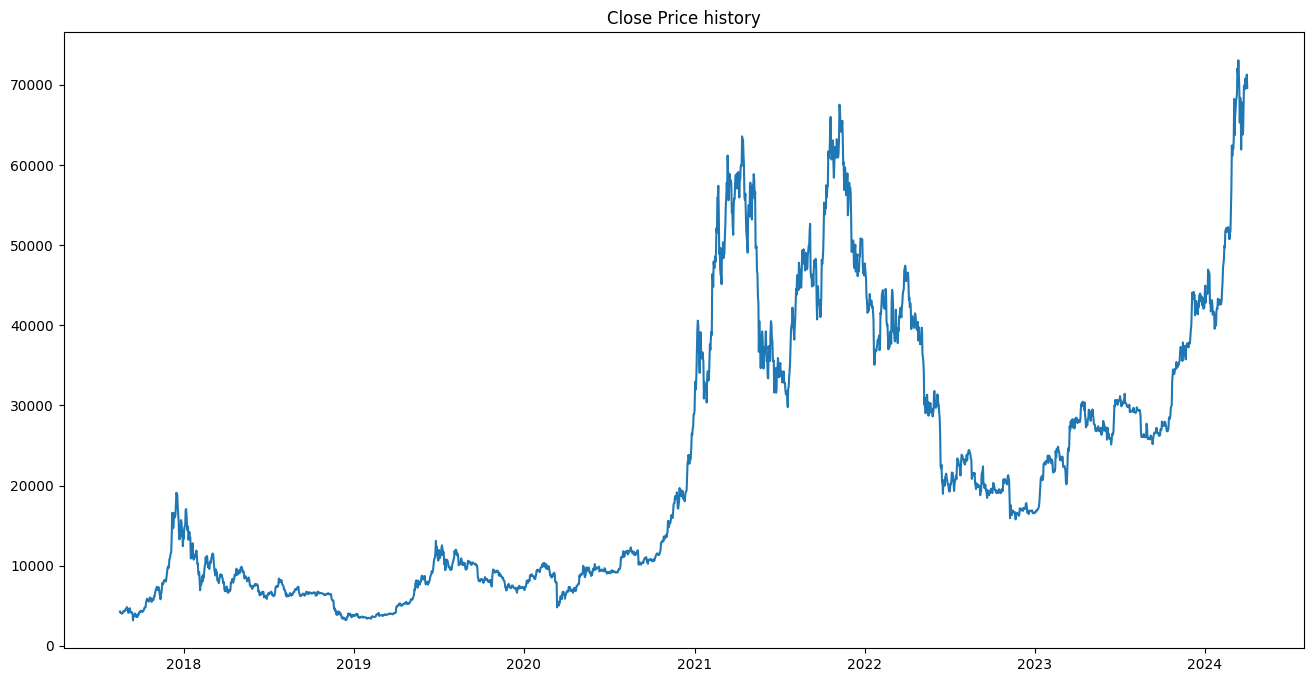

In [45]:
def build_model(train,valid,new_data,scaler,params,
                scaled_data_train,scaled_data_valid,dados):    
    
    #creating the training set in the required format
    #we will put together 60 days (offset) of data together and treat that as single input 
    #and the target value is the 'Close' price on the next day

    x_train, y_train = [], []
    dados_keys = list(dados.keys())
    for i in range(params['offset'], len(train)):
        arg = []
        for j in range(0, len(dados_keys) - 1):
            arg.append(scaled_data_train[i-params['offset']:i, j])
        
        x_train.append(arg)
        y_train.append(scaled_data_train[i, dados_keys.index(params['target_column']) - 1])
    
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[2],x_train.shape[1]))
    
    #creating a new dataframe which will be used to create the test set
    inputs = new_data[len(new_data) - len(valid) - params['offset']:].values
    #inputs = inputs.reshape(-1,1)
    inputs = scaler.transform(inputs)
    
    X_test, Y_test = [], []
    for i in range(params['offset'],inputs.shape[0]):
        arg = []
        for j in range(0, len(dados_keys) - 1):
            arg.append(inputs[i-params['offset']:i, j])
        
        X_test.append(arg)
        Y_test.append(inputs[i, dados_keys.index(params['target_column']) - 1])
    
    X_test, Y_test = np.array(X_test), np.array(Y_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[2],X_test.shape[1]))    
    
    #create and fit the LSTM network
    #we are building a general model here. This section of code will be used in further steps
    #where we will check if only 1 hidden layer can give better results
    #so an if-else loop is created to combat that situaiton
    
    if len(params["units"]) != len(params["drop_rate"]):
        print("Units possui tamanho diferente de drop_rate. Saindo.")
        exit(1)
    
    model = Sequential()

    # Adds the first layer
    model.add(LSTM(units=params['units'][0], return_sequences=True, 
                    input_shape=(x_train.shape[1], len(dados_keys) - 1)))
    model.add(Dropout(rate=params['drop_rate'][0]))

    # Adds all the other layers (if they exists)
    for i in range(1, len(params["units"]) - 2):
        model.add(LSTM(units=params['units'][i], return_sequences=True))
        model.add(Dropout(rate=params['drop_rate'][i]))

    model.add(LSTM(units=params['units'][-1]))
    model.add(Dropout(rate=params['drop_rate'][-1]))
    
    # Finishes with the last Dense layer
    model.add(Dense(params['no_of_outputs']))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(x_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], 
                        verbose=1, validation_data=[X_test, Y_test])
    
    return model, history, X_test

def get_accuracy(train,valid,new_data,tl, 
                 scaler,model,X_test,params,dados):
    
    dados_keys = list(dados.keys())
    
    closing_price = model.predict(X_test)
    
    new_scaler = MinMaxScaler(feature_range=(0, 1))
    new_scaler.min_ , new_scaler.scale_ = scaler.min_[1], scaler.scale_[1]
    
    closing_price = new_scaler.inverse_transform(closing_price)
    
    train = new_data[:tl]
    valid = new_data[tl:]
    valid['Predictions'] = closing_price
    
    #for plotting
    plt.figure(figsize=(16,8))
    plt.plot(train[dados[params['target_column']]])
    plt.plot(valid[dados[params['target_column']]], label=params['target_label'])
    plt.plot(valid['Predictions'], label=params['predict_label'])
    plt.legend()
    plt.savefig('Predicted-Close.png')
    
    #RMS error
    rms = np.sqrt(np.mean(np.power((valid-closing_price),2)))
    
    #R-squared
    y_true = valid[dados[params['target_column']]]
    y_pred = valid['Predictions']
    r = r2_score(y_true, y_pred)
    
    return rms, r  
   
def run(data_df, params, dados, inputs):    
    
    #Plot the data and check if there are any unexpected anamolies(sudden spikes or dips)
    plt.figure(figsize=(16,8))
    plt.plot(data_df[dados[params['target_column']]], label=params["history_label"])
    plt.title(params["history_label"])
    
    #In our model, we will try to predict the future close price of a stock using the past
    #open and close prices of that particular stock. So let's a create a new dataframe with 
    #only the 'Date', 'Open' and 'Close' price columns

    #new_data = pd.DataFrame(index=range(0,len(data_df)),columns=dados.keys())
    new_columns = []
    for key in dados.keys():
        new_columns.append(dados[key])

    new_data = pd.DataFrame(index=range(0,len(data_df)),columns=new_columns)

    for i in range(0,len(data_df)):
        for key in dados.keys():
            if key == "Date":
                new_data[dados["Date"]][i] = data_df.index[i]
                continue

            new_data[dados[key]][i] = data_df[dados[key]][i]
        
    #setting 'Date' column as index and dropping the original column
    new_data.index = new_data.Date
    new_data.drop(dados["Date"], axis=1, inplace=True)
    
    #80% of the data is used as training set and 20% as test set
    #'test set' here is referred to as 'validatation set'
    frac = 0.8
    tl = int(len(new_data)*frac)
    
    dataset = new_data.values
    train = dataset[0:tl,:]
    valid = dataset[tl:,:]
    
    #Normalizing the data
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(train)
    scaled_data_train = scaler.transform(train)
    scaled_data_valid = scaler.transform(valid)
    
    #building the LSTM model
    model, history, X_test = build_model(train,valid,new_data,scaler,params,
                                         scaled_data_train,scaled_data_valid,dados)
    
    #getting the 'RMSE error' and 'R-squared value'
    rms, r = get_accuracy(train,valid,new_data,tl,
                          scaler,model,X_test, params, dados)
    
    print(f'RMS: {rms}, R-square: {r}')

if __name__ == '__main__':
    #read dados json file
    with open("dados.json", "r") as json_file:
        dados = json.load(json_file)
    
    #Readind the data and changing it into pandas dataframe
    data_df = pd.read_csv('dadosBinance.csv', index_col='Date', parse_dates=True)

    datasList = pd.read_csv('dadosBinance.csv')
    list_open = datasList['Open'].tolist()
    list_high = datasList['high'].tolist()
    list_low = datasList['low'].tolist()
    list_close = datasList['Close'].tolist()
    list_volume = datasList['volume'].tolist() 
    
    inputs = {
    'open': np.array(list_open),
    'high': np.array(list_high),
    'low': np.array(list_low),
    'close': np.array(list_close),
    'volume': np.array(list_volume)
    }

    sma = SMA(inputs.get('close'), timeperiod=60)
    print('SMA: ', sma)
    print('Tamanho SMA: ', len(sma))
    ema = EMA(inputs, timeperiod=60)
    print('EMA: ', ema)
    print('Tamanho EMA: ', len(ema))
    rsi = RSI(inputs, timeperiod=60)
    print('RSI: ', rsi)
    print('Tamanho RSI: ', len(rsi))
    # Calcular as Bandas de Bollinger
    #nbdevup é o número de desvios padrão para a banda superior.
    #nbdevdn é o número de desvios padrão para a banda inferior.
    #upper_band, middle_band, lower_band = BBANDS(inputs.get('close'), timeperiod=60, nbdevup=2, nbdevdn=2)
    macd, signal, hist = MACD(inputs.get('close'), fastperiod=12, slowperiod=26, signalperiod=9)
    print('MACD: ', macd)
    print('Tamanho MACD: ', len(macd))
    engulfing_pattern = CDLENGULFING(inputs.get('open'), inputs.get('high'), inputs.get('low'), inputs.get('close'))
    print('Engulfing: ', engulfing_pattern)
    print('Tamanho Engulfing: ', len(engulfing_pattern))
    doji = CDLDOJI(inputs.get('open'), inputs.get('high'), inputs.get('low'), inputs.get('close'))
    print('Doji: ', doji)
    print('Tamanho Doji: ', len(doji))

    #New readind the data and changing it into pandas dataframe
    data_df['sma'] = sma
    #display(data_df)
    #Defining the initial parameters of the model    
    params = {'offset':60,
             'units': [32, 32, 32, 32],
             'drop_rate': [0, 0, 0, 0],
             'batch_size':5,
             'epochs':20,   
             'no_of_outputs':1,
             'target_column': 'parameter2',
             'target_label': 'Actual Close Price',
             'predict_label': 'Predicted Close Price',
             'history_label': 'Close Price history'
             }    

    run(data_df, params, dados, inputs)